https://machine-learning.club

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import f1_score, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd
import shap

In [2]:
def create_dummies(data, column_name: str, prefix_name: str):
    dummie = pd.get_dummies(data[column_name], prefix=prefix_name) # Create columsn for all the possibilities in column
    dummie = dummie.astype(int) # Convert boolean values to integers
    data.drop(column_name, axis=1, inplace=True) # Drop the attribute
    return dummie

In [3]:
def get_importances(clf):
	# Dictionary: Feature → Importance in %
    importances = {
        feature: round(importance * 100, 2)
        for feature, importance in zip(clf.feature_names_in_, clf.feature_importances_)
    }
    sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)
    return sorted_importances
	#formatted = [f"'{feature}' impact: {importance:.2f}%" for feature, importance in sorted_importances]
	#return formatted


In [ ]:
def get_grid(model_regressor, x_train, y_train) -> GridSearchCV:
    # search for the perfect grid to get the max depth
	param_grid = {
    'max_depth':  list(range(2, 21)),
    'criterion': ['gini', 'entropy']
	}	
	find_grid = GridSearchCV(
		estimator=model_regressor,
  		scoring='f1',
		param_grid=param_grid,
		cv=5, # cross-validation with 5 folds
	)
	find_grid.fit(x_train, y_train)
	return find_grid

In [ ]:
def handle_nan(x_train, y_train) -> tuple:
	# Remove rows with NaN values
    x_train_new = x_train.dropna()
    
    # Adapt `y_train` to the remaining lines
    y_train_new = y_train[x_train_new.index]

	# Add new data to blance the outcome
    smote = SMOTE(sampling_strategy='minority')
    x_train_new, y_train_new = smote.fit_resample(x_train_new, y_train_new)

    return (x_train_new, y_train_new)

		

In [6]:
def visualize(clf):
    sorted_importances = get_importances(clf)
 	# Erstelle den Plot
    features = [item[0] for item in sorted_importances]
    values = [item[1] for item in sorted_importances]

    plt.figure(figsize=(12, 8))
    plt.barh(features, values, color='teal')
    plt.xlabel('Importance (%)')
    plt.title('Feature Importances')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [7]:
data = pd.read_csv("data/training_data.csv")

# Get all dummies
gender_dummie = create_dummies(data, "gender", "gender")
work_dummie = create_dummies(data, "work_type", "work")
smoking_dummie = create_dummies(data, "smoking_status", "smoking_status")
residence_dummie = create_dummies(data, "Residence_type", "Residence_type")
married_dummie = create_dummies(data, "ever_married", "married")

# Add all dummies to one data frame & add it to the main data frame
data_dummies = pd.concat([gender_dummie, work_dummie, smoking_dummie, residence_dummie, married_dummie], axis=1)
data = pd.concat([data, data_dummies], axis=1)

# Drop the following columns
data = data.drop(["id"], axis=1)

In [22]:
x_train = data.drop("stroke", axis=1)
y_train = data["stroke"]

# TODO: change class_weight
clf = DecisionTreeClassifier(criterion='entropy', random_state=42, class_weight={0: 1, 1: 3})
clf = clf.fit(x_train,y_train)


find_grid = get_grid(clf, x_train, y_train)
max_depth = find_grid.best_params_['max_depth']

print("Best max_depth:", max_depth)

Best max_depth: 7


### To fine tune the Classifier

In [23]:
x = data.drop("stroke", axis=1)
y = data["stroke"]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.4)
x_train, y_train = handle_nan(x_train, y_train)


F1 Score: 18.77% 



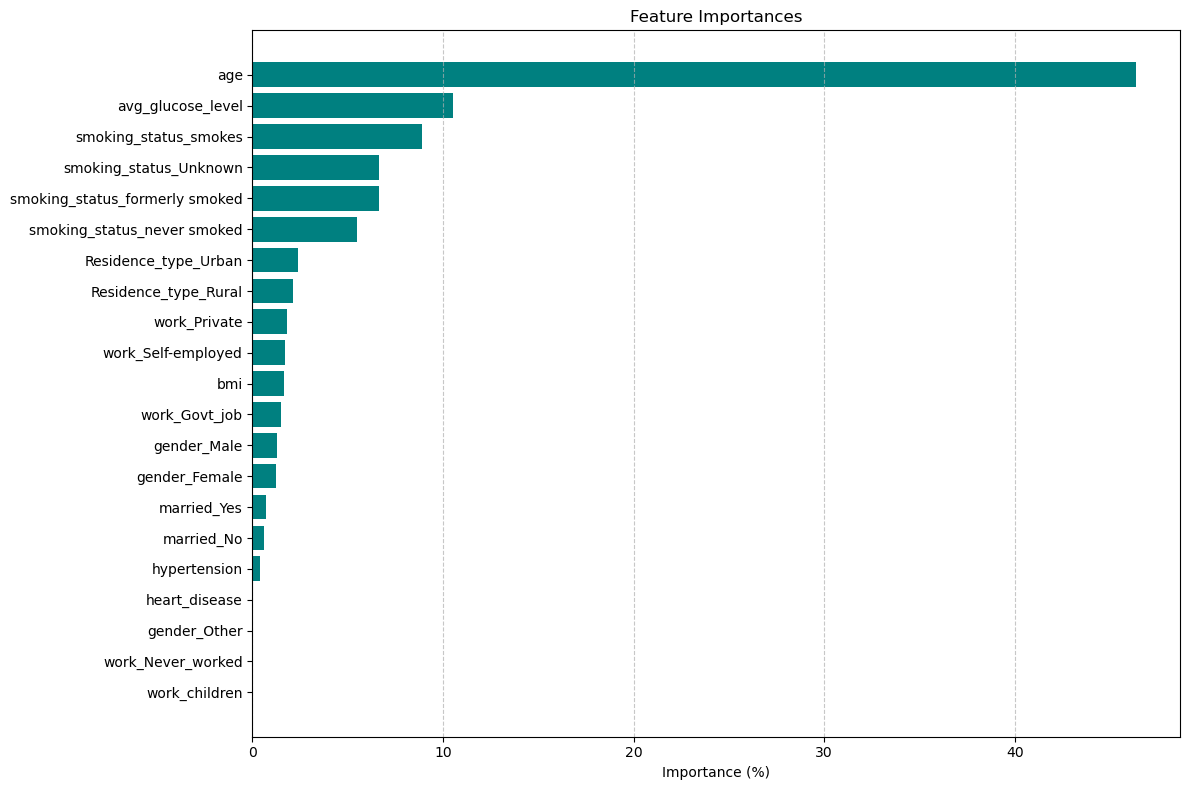

In [24]:
clf = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=max_depth, min_samples_leaf=2, min_samples_split=5, class_weight={0: 1, 1: 3})
clf = clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

acc = f1_score(y_test,y_pred,average='binary')
print(f"F1 Score: {round(acc * 100, 2)}% \n")

visualize(clf)


---

#### Confuisionmatrix

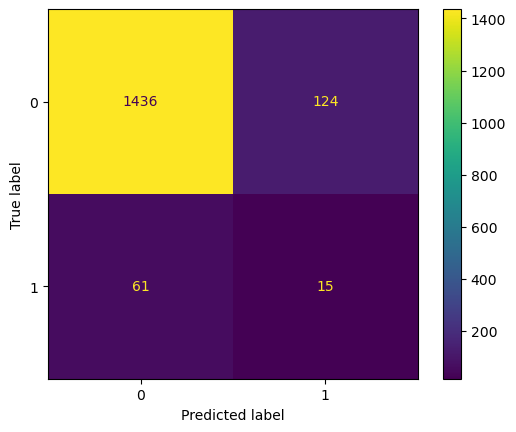

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# plot decussion tree
#tree.plot_tree(clf)

---

#### Distribution of the output

stroke
0    0.5
1    0.5
Name: proportion, dtype: float64


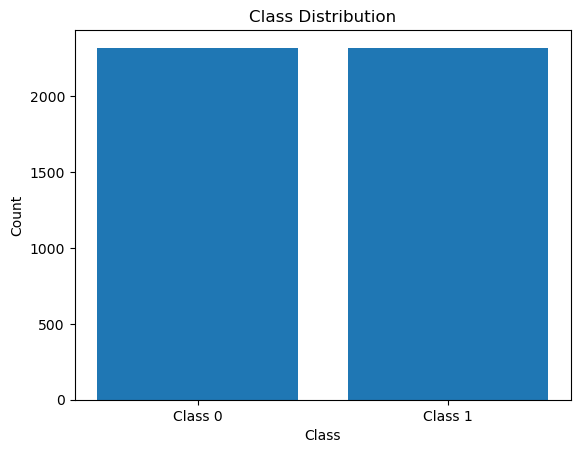

In [ ]:
# Shows us how imbalanced the stroke is -> reason for the bad results
print(pd.Series(y_train).value_counts(normalize=True))

# Show the distribution as a plot
count_class = y_train.value_counts()
plt.bar(count_class.index, count_class.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(count_class.index, ['Class 0', 'Class 1'])
plt.show()